NC Ratio Calculation

In [12]:
import cv2
import numpy as np
import os

def read_images():
    nc_ratios = []
    file_list = ['test', 'train', 'val']
    for str in file_list:
        for filename in os.listdir(str):
            image = cv2.imread(str + "/" + filename)
            height, width, channel = image.shape
            cropped_image = image[0:height, width//2:width] 
            image_testing = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

            unique_values, counts = np.unique(image_testing, return_counts=True)
            nucleus = counts[0]
            cytoplasm = counts[1]
            nc_ratio = nucleus / (cytoplasm + nucleus)
            nc_ratios.append(float(nc_ratio))
    return nc_ratios

How malignant is the population of cells?

Null Hypothesis: The mean NC ratio is less than or equal to the threshold

Alternative Hypothesis: The mean NC ratio is greater than the threshold

In [13]:
import scipy.stats as stats

def z_test(data_list, threshold):
    total = sum(data_list)
    mean = total / len(data_list)

    x = 0
    for i in data_list:
        x += (i - mean)**2
    variance = x / (len(data_list) - 1)
    stdev = variance ** 0.5

    n = len(data_list)

    p = 0.05
    z_value = (mean - threshold) / (stdev / n ** 0.5)
    p_value = float(1 - stats.norm.cdf(z_value))
    if p_value > p:
        return p_value, True
    else:
        return p_value, False
    
p_value, boolean = z_test(read_images(), 0.3)
if boolean:
    print(f"Fail to reject the null hypothesis. The p-value, {p_value}, is greater than 0.05. In other words, the population of cells is likely not cancerous")
else:
    print(f"Reject the null hypothesis. The p-value, {p_value}, is less than 0.05. In other words. the population of cells is likely cancerous")

Fail to reject the null hypothesis. The p-value, 0.311597865547957, is greater than 0.05. In other words, the population of cells is likely not cancerous


In [14]:
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm

In [15]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p
    
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out
    


In [16]:
input_image = torch.rand((1,3,256,256))
model = UNet(3,10)
output = model(input_image)
print(output.size())

torch.Size([1, 10, 256, 256])


In [48]:
class CellDataset(Dataset):
    def __init__(self, path):
        self.path = path

        self.images = []
        self.masks = []
        
        for filename in os.listdir(path):
            self.images.append(path + "/" + filename)
            self.masks.append(path + "/" + filename)

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()])
        

    def __getitem__(self, index):
        image = Image.open(self.images[index])
        width, height = image.size
        img = image.crop((0, 0, width//2, height))
        mask = image.crop((width//2, 0, width, height))
        mask = mask.convert("L")
        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)

In [49]:
train_dataset = CellDataset('train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = CellDataset('val')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

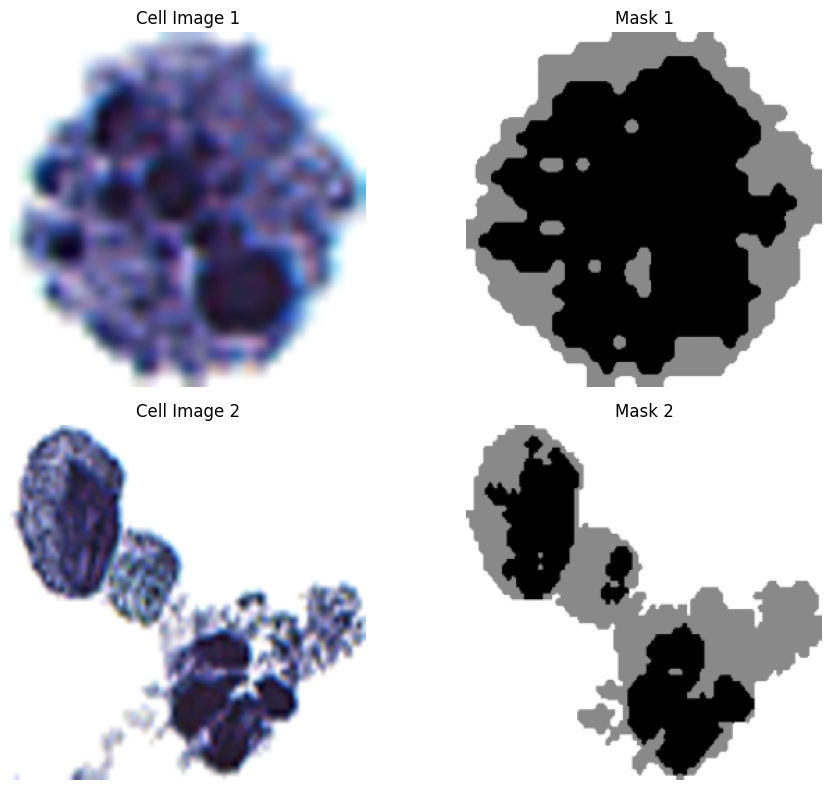

In [50]:
import matplotlib.pyplot as plt

def visualize_cell_dataset(dataset, num_samples=3):

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    
    for i in range(num_samples):
        img, mask = dataset[i]
        
        img_np = img.permute(1, 2, 0).numpy()
        mask_np = mask.permute(1, 2, 0).numpy()
        
        img_np = img_np
            
        mask_np = mask_np
        
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f"Cell Image {i+1}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_np, cmap='gray')
        
        axes[i, 1].set_title(f"Mask {i+1}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_cell_dataset(train_dataset, num_samples=2)

In [20]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [21]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [ ]:
train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(25)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, img_mask in enumerate(tqdm(train_loader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)
        
        optimizer.zero_grad()
        
        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item()
        train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_loader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask)
            
            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)

torch.save(model.state_dict(), 'model.pth')

  0%|          | 0/13 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:54<21:56, 54.85s/it]

------------------------------
Training Loss EPOCH 1: 0.6991
Training DICE EPOCH 1: 0.0694


Validation Loss EPOCH 1: 0.6875
Validation DICE EPOCH 1: 0.7741
------------------------------


  8%|▊         | 2/25 [02:12<26:15, 68.49s/it]

------------------------------
Training Loss EPOCH 2: 0.6543
Training DICE EPOCH 2: 0.7941


Validation Loss EPOCH 2: 0.6051
Validation DICE EPOCH 2: 0.7902
------------------------------


 12%|█▏        | 3/25 [03:09<23:08, 63.11s/it]

------------------------------
Training Loss EPOCH 3: 0.5756
Training DICE EPOCH 3: 0.7814


Validation Loss EPOCH 3: 0.5384
Validation DICE EPOCH 3: 0.8130
------------------------------


 16%|█▌        | 4/25 [04:05<21:08, 60.42s/it]

------------------------------
Training Loss EPOCH 4: 0.5126
Training DICE EPOCH 4: 0.8139


Validation Loss EPOCH 4: 0.4941
Validation DICE EPOCH 4: 0.8085
------------------------------


 20%|██        | 5/25 [05:15<21:11, 63.57s/it]

------------------------------
Training Loss EPOCH 5: 0.4709
Training DICE EPOCH 5: 0.7992


Validation Loss EPOCH 5: 0.4589
Validation DICE EPOCH 5: 0.7816
------------------------------


 24%|██▍       | 6/25 [06:36<22:04, 69.72s/it]

------------------------------
Training Loss EPOCH 6: 0.4622
Training DICE EPOCH 6: 0.7876


Validation Loss EPOCH 6: 0.4468
Validation DICE EPOCH 6: 0.8004
------------------------------


 28%|██▊       | 7/25 [07:43<20:34, 68.60s/it]

------------------------------
Training Loss EPOCH 7: 0.4440
Training DICE EPOCH 7: 0.8016


Validation Loss EPOCH 7: 0.4448
Validation DICE EPOCH 7: 0.8130
------------------------------


 32%|███▏      | 8/25 [08:36<18:02, 63.68s/it]

------------------------------
Training Loss EPOCH 8: 0.4440
Training DICE EPOCH 8: 0.8097


Validation Loss EPOCH 8: 0.4447
Validation DICE EPOCH 8: 0.8119
------------------------------


 36%|███▌      | 9/25 [09:30<16:12, 60.76s/it]

------------------------------
Training Loss EPOCH 9: 0.4314
Training DICE EPOCH 9: 0.8140


Validation Loss EPOCH 9: 0.4373
Validation DICE EPOCH 9: 0.8141
------------------------------


 40%|████      | 10/25 [10:29<15:04, 60.31s/it]

------------------------------
Training Loss EPOCH 10: 0.4326
Training DICE EPOCH 10: 0.8156


Validation Loss EPOCH 10: 0.4357
Validation DICE EPOCH 10: 0.8108
------------------------------


 44%|████▍     | 11/25 [11:38<14:41, 62.97s/it]

------------------------------
Training Loss EPOCH 11: 0.4272
Training DICE EPOCH 11: 0.8126


Validation Loss EPOCH 11: 0.4319
Validation DICE EPOCH 11: 0.8164
------------------------------


 48%|████▊     | 12/25 [12:55<14:34, 67.28s/it]

------------------------------
Training Loss EPOCH 12: 0.4297
Training DICE EPOCH 12: 0.8136


Validation Loss EPOCH 12: 0.4420
Validation DICE EPOCH 12: 0.8045
------------------------------


 52%|█████▏    | 13/25 [14:10<13:52, 69.39s/it]

------------------------------
Training Loss EPOCH 13: 0.4271
Training DICE EPOCH 13: 0.8134


Validation Loss EPOCH 13: 0.4351
Validation DICE EPOCH 13: 0.8121
------------------------------


 56%|█████▌    | 14/25 [15:40<13:51, 75.57s/it]

------------------------------
Training Loss EPOCH 14: 0.4275
Training DICE EPOCH 14: 0.8108


Validation Loss EPOCH 14: 0.4302
Validation DICE EPOCH 14: 0.8143
------------------------------


 60%|██████    | 15/25 [16:59<12:48, 76.84s/it]

------------------------------
Training Loss EPOCH 15: 0.4247
Training DICE EPOCH 15: 0.8125


Validation Loss EPOCH 15: 0.4324
Validation DICE EPOCH 15: 0.8106
------------------------------


 64%|██████▍   | 16/25 [18:09<11:13, 74.78s/it]

------------------------------
Training Loss EPOCH 16: 0.4229
Training DICE EPOCH 16: 0.8137


Validation Loss EPOCH 16: 0.4255
Validation DICE EPOCH 16: 0.8183
------------------------------


 68%|██████▊   | 17/25 [19:23<09:55, 74.45s/it]

------------------------------
Training Loss EPOCH 17: 0.4235
Training DICE EPOCH 17: 0.8150


Validation Loss EPOCH 17: 0.4274
Validation DICE EPOCH 17: 0.8154
------------------------------


 72%|███████▏  | 18/25 [20:58<09:24, 80.68s/it]

------------------------------
Training Loss EPOCH 18: 0.4227
Training DICE EPOCH 18: 0.8165


Validation Loss EPOCH 18: 0.4326
Validation DICE EPOCH 18: 0.8056
------------------------------


 76%|███████▌  | 19/25 [22:36<08:35, 85.84s/it]

------------------------------
Training Loss EPOCH 19: 0.4300
Training DICE EPOCH 19: 0.8119


Validation Loss EPOCH 19: 0.4380
Validation DICE EPOCH 19: 0.8245
------------------------------


 80%|████████  | 20/25 [23:59<07:05, 85.12s/it]

------------------------------
Training Loss EPOCH 20: 0.4232
Training DICE EPOCH 20: 0.8201


Validation Loss EPOCH 20: 0.4291
Validation DICE EPOCH 20: 0.8121
------------------------------


 84%|████████▍ | 21/25 [25:31<05:47, 86.96s/it]

------------------------------
Training Loss EPOCH 21: 0.4212
Training DICE EPOCH 21: 0.8143


Validation Loss EPOCH 21: 0.4249
Validation DICE EPOCH 21: 0.8198
------------------------------


 88%|████████▊ | 22/25 [27:04<04:26, 88.87s/it]

------------------------------
Training Loss EPOCH 22: 0.4395
Training DICE EPOCH 22: 0.8122


Validation Loss EPOCH 22: 0.4419
Validation DICE EPOCH 22: 0.8184
------------------------------


 92%|█████████▏| 23/25 [28:42<03:03, 91.66s/it]

------------------------------
Training Loss EPOCH 23: 0.4285
Training DICE EPOCH 23: 0.8190


Validation Loss EPOCH 23: 0.4305
Validation DICE EPOCH 23: 0.8159
------------------------------


 96%|█████████▌| 24/25 [30:00<01:27, 87.63s/it]

------------------------------
Training Loss EPOCH 24: 0.4223
Training DICE EPOCH 24: 0.8119


Validation Loss EPOCH 24: 0.4261
Validation DICE EPOCH 24: 0.8191
------------------------------


100%|██████████| 25/25 [31:23<00:00, 75.33s/it]


------------------------------
Training Loss EPOCH 25: 0.4215
Training DICE EPOCH 25: 0.8172


Validation Loss EPOCH 25: 0.4289
Validation DICE EPOCH 25: 0.8101
------------------------------


In [27]:
def threshold_mask(mask):
    thresholded_mask = np.zeros_like(mask, dtype=np.float32)
    
    thresholded_mask[mask < 0.3] = 0.0  # Black
    thresholded_mask[(mask >= 0.3) & (mask < 0.7)] = 0.5  # Gray
    thresholded_mask[mask >= 0.7] = 1.0  # White
    
    return thresholded_mask

[0.11372549 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334
 0.13725491 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275
 0.16078432 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216
 0.18431373 0.1882353  0.19215687 0.19607843 0.2        0.20392157
 0.20784314 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098
 0.23137255 0.23529412 0.23921569 0.24313726 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.34117648 0.34509805 0.34901962
 0.3529412  0.35686275 0.36078432 0.3647059  0.36862746 0.37254903
 0.3764706  0.38039216 0.38431373 0.3882353  0.39215687 0.39607844
 0.4        0.40392157 0.40784314 0.4117647  0.41568628 0.41960785
 0.42352942 0.42745098 0.43137255 0.43529412 0.4392157  0.44313726
 0.44705883 0.4509804  0.45490196 0.45882353 0.4627451  0.4666666

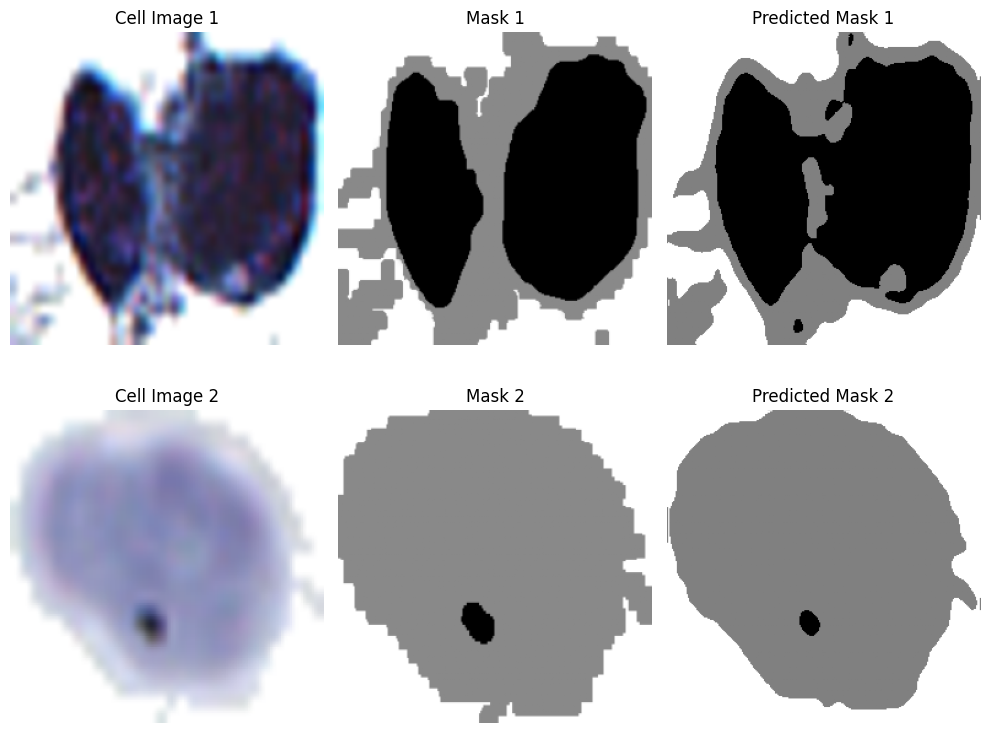

In [ ]:
def visualize_model(dataset, num_samples=3):

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 4*num_samples))
    
    for i in range(num_samples):
        img, mask = dataset[i]

        model.load_state_dict(torch.load('model.pth', map_location=torch.device(device)))
        
        pred_mask = model(img.unsqueeze(0).to(device))
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = threshold_mask(pred_mask.squeeze().cpu().detach().numpy())

        img_np = img.permute(1, 2, 0).numpy()
        mask_np = mask.permute(1, 2, 0).numpy()
        
        img_np = img_np
            
        mask_np = mask_np
        
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f"Cell Image {i+1}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask {i+1}")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

test_dataset = CellDataset('test')

visualize_model(test_dataset, num_samples=2)

In [53]:
def nc_ratio(image):
    unique_values, counts = np.unique(image, return_counts=True)
    nucleus = counts[0]
    cytoplasm = counts[1]
    nc_ratio = nucleus / (cytoplasm + nucleus)
    return nc_ratio

def MAE_and_Results(dataset):
    nc_ratios_real = []
    nc_ratios_pred = []
    for i in range(len(dataset)):
        img, mask = dataset[i]

        model.load_state_dict(torch.load('model.pth', map_location=torch.device(device)))
        
        pred_mask = model(img.unsqueeze(0).to(device))
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = threshold_mask(pred_mask.squeeze().cpu().detach().numpy())
        mask = threshold_mask(mask)

        nc_ratios_real.append(nc_ratio(mask))
        nc_ratios_pred.append(nc_ratio(pred_mask))
    mae = np.mean(np.abs(np.array(nc_ratios_real) - np.array(nc_ratios_pred)))
    return mae

print(f"Mean Absolute Error: {MAE_and_Results(test_dataset)}")

Mean Absolute Error: 0.09799063586787286
